In [1]:
import Pkg; Pkg.add(["Plots", "Interact", "Polynomials"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/Project.toml`
  No Changes to `~/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; default(l=5, size=(900,550), label=false);
using Printf;

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), v)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end

imshow (generic function with 1 method)

### Warmup

Let $P \in \mathbb{C}^{m \times m}$ be given, and let $P = \hat{U} \hat{\Sigma} \hat V^*$ be an SVD of $P$
containing just the nonzero singular values.

True or False?

$$\|P\|_2 = 1 \quad\Leftrightarrow\quad \| \hat{\Sigma} \|_2 = 1 \quad\Leftrightarrow\quad \Sigma = I \quad\Leftrightarrow\quad
P = \hat{U} \hat{V}^*.$$

# Conditioning and Condition Number

**1. Condition of a problem**

**2. Condition of Matrix-Vector Multiplication**

**3. Condition of a System of Equations**

> _Conditioning_ pertains to the perturbation behavior of a mathematical problem.

> _Stability_ pertains to the perturbation behavior of an algorithm used to solve that problem on a computer.

## Condition of a problem

Many problems we consider are functions between normed vector spaces:

$$f: X \to Y$$

$$X = \text{ data}$$

$$Y = \text{ solutions}$$

Many (most) problems behave differently for different datapoints (_problem instances_) $x$:
    
    

- A rubber band that stretches under one load snaps under another

- Linear operations $C \gets A B$ or $x \gets A^{-1}y$ are the exception: linearity $\Rightarrow$ scale invariance $\Rightarrow$ all problem instances have (roughly) similar behavior.

### [Hadamard's Well-posed problem](https://en.wikipedia.org/wiki/Well-posed_problem)

> 1) A solution exists
>
> 2) The solution is unique
>
> **3) The solution's behaviour changes continuously with the data.**


### Example: chaotic attractors

- Data $x$: initial conditions
- Solution $y$: state at fixed time $T$

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/tmp.gif")
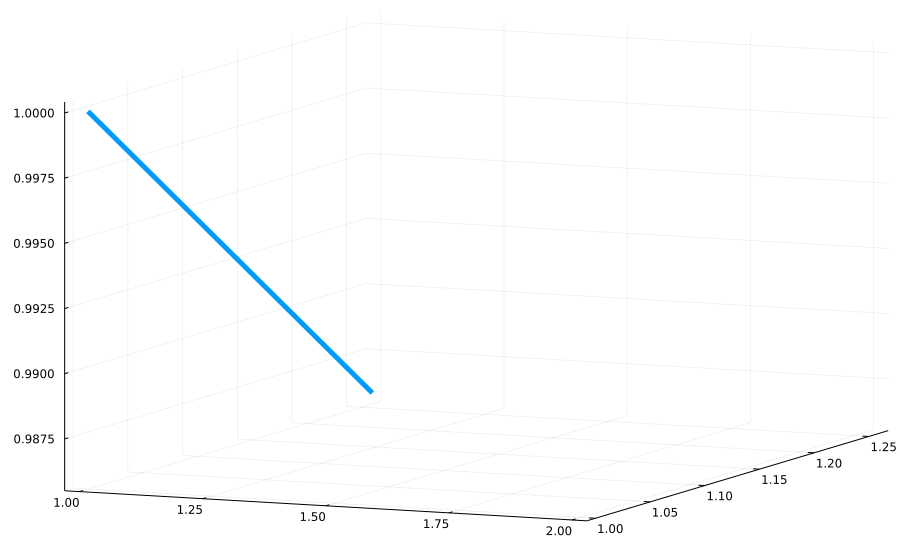

In [4]:
# https://github.com/JuliaPlots/ExamplePlots.jl/blob/master/notebooks/scratch/lorenz.ipynb

# initialize the attractor
n = 6000
dt = 0.01
σ, ρ, β = 10., 28., 8/3
x, y, z = 1., 1., 1.
X, Y, Z = [x], [y], [z]

# initialize a Plots animation
anim = Animation()

# process n steps
for i=1:n
    dx = σ*(y - x);      x += dt * dx; push!(X,x)
    dy = x*(ρ - z) - y;  y += dt * dy; push!(Y,y)
    dz = x*y - β*z;      z += dt * dz; push!(Z,z)
    
    # plot and save to the animation
    if mod1(i,10) == 1
        frame(anim, plot3d(X,Y,Z))
    end
end

# build an animated gif
gif(anim)

1. A solution exists? ✅

2. The solution is unique? ✅

3. The solution $f: X \to Y$ is continuous? 😕

- Technically yes
- But for a late time $T$, exponentially fine resolution is required to $\|f(x + \delta x) - f(x)\|$ to be close to $x$.

### Instead of the binary ({continuous, discontinuous}), we have the spectrum of _condititioning_ (sensitivity)

- A _well-conditioned_ problem: small perturbations of $x$ lead to only small changes in $f(x)$

- An _ill-conditioned_ problem: small perturbations of $x$ lead to a large change in $f(x)$.

- Small? Large?

### Absolute Condition Number $\hat{\kappa}$

- $\delta x$: small perturbation of $x$

- Define

$$\delta f = f(x + \delta x) - f(x)$$

- The _absolute condition number_

$$\hat\kappa(x) = \lim_{\rho \to 0} \sup_{\|\delta x\| \leq \rho} \frac{\|\delta f\|}{\|\delta x\|}$$

(Compare derivative: $\lim_{\epsilon \to 0} \frac{f(x + \epsilon\delta x) - f(x)}{\epsilon}$)

(Compare Lipschitz constant: $\frac{\|\delta f\|}{\|\delta x\|} \leq L_x$ )

### Case: $f$ differentiable

$$f(x + \delta x) = f(x) + \underbrace{J(x)}_{\text{Jacobian}}\delta x + o(\|\delta x\|), \quad J(x)\in \mathbb{C}^{m \times n}.$$

**Exercise.**

$$\|\hat{\kappa}(x)\| = \|J(x)\|.$$

### Relative Condition Number $\kappa$

$$\kappa(x) = \lim_{\delta \to 0} \sup_{\|\delta x\| \leq \delta} \frac{\left(\frac{\|\delta f\|}{\|f \|}\right)}{\left(\frac{\|\delta x\|}{\|x\|}\right)}$$

$$\kappa(x) = \frac{\|J(x)\|}{\left(\frac{\|f(x)\|}{\|x\|}\right)}, \quad\text{(}f\text{ differentiable)}$$

- Think change of units:

  - Does a problem become more challenging if we switch $Y$ from km to m?
  - Does a problem become harder if we switch $X$ from days to years? 

### In this class we focus on $\kappa$ (relative), not $\hat\kappa$ (absolute)

- When we are comparing conditioning (problem) to stability (algorithm), the most important scale of $\delta$s we care about is rounding error, and rounding errors are relative

### Examples

$$f: x \to x / 2$$

$\kappa(x)?$

$$\kappa(x)=\frac{\|J(x)\|}{\|f(x)\|/\|x\|}=\frac{1/2}{|x/2|/|x|}=1$$

$$f: x \to \sqrt{x}$$

$\kappa(x)$?

$$\kappa(x)=\frac{1/(2\sqrt{x})}{|\sqrt{x}|/|x|}=\frac{1}{2}$$

### Example: cancellation

$$f(x) = x_1 - x_2.$$

$\kappa(x)?$

$$\kappa(x)=\frac{\|[1,-1]\|}{|x_1-x_2|/\|[x_1,x_2]\|}$$

### Example: polynomial roots from coefficients

- Data: coefficients of a polynomial
- Solution: roots

Consider data

$$x^2 + 2x + 1 = (x-1)^2.$$

In [5]:
using Polynomials

err = 1.e-1
p1, p2 = roots(Polynomial([1.0 - err, -2.0, 1.0]))

2-element Vector{Float64}:
 0.6837722339831621
 1.316227766016838

In [6]:
df = norm([p1, p2] - [1.0, 1.0])
fnorm = norm([p1, p2])
dx = err
xnorm = norm([1.0, -2.0, 1.0])

(df / fnorm) / (dx / xnorm)

7.385489458759964

In [7]:
p = fromroots(collect(1.0:1.0:20.0) ./ 20.)

Polynomial(2.320196159531251e-8 - 1.6694923470996095e-6*x + 5.2657164587557634e-5*x^2 - 0.0009819741245384974*x^3 + 0.012264727512580951*x^4 - 0.10986265618736596*x^5 + 0.7364793724245446*x^6 - 3.8004595112474453*x^7 + 15.388381860179422*x^8 - 49.522948562067626*x^9 + 127.68896587308544*x^10 - 264.8148103506445*x^11 + 441.80769513207025*x^12 - 590.711862890625*x^13 + 627.68393171875*x^14 - 522.58775625*x^15 + 333.29966249999995*x^16 - 157.10625*x^17 + 51.537499999999994*x^18 - 10.499999999999998*x^19 + 1.0*x^20)

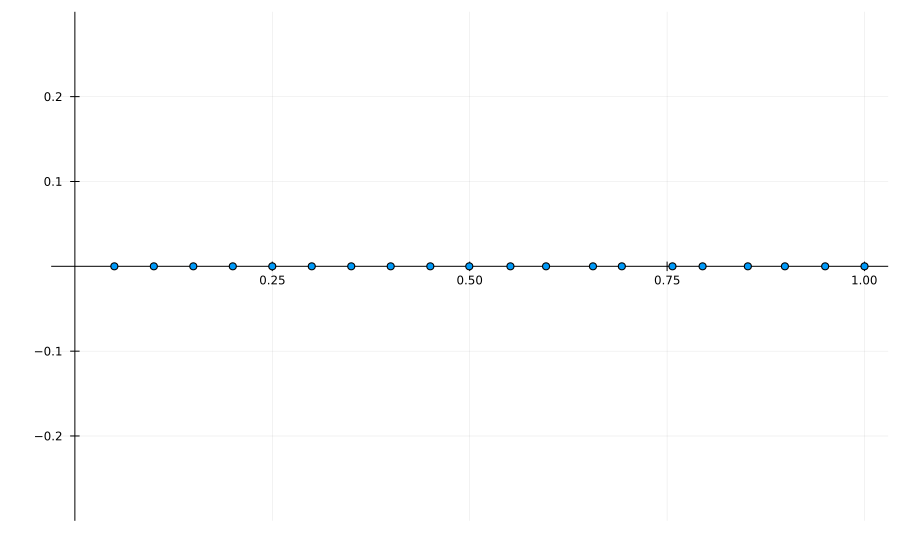

In [8]:
r = roots(p)
plt = plot(real(r), imag(r), st=:scatter, ylim=(-0.3,0.3), framestyle=:origin)

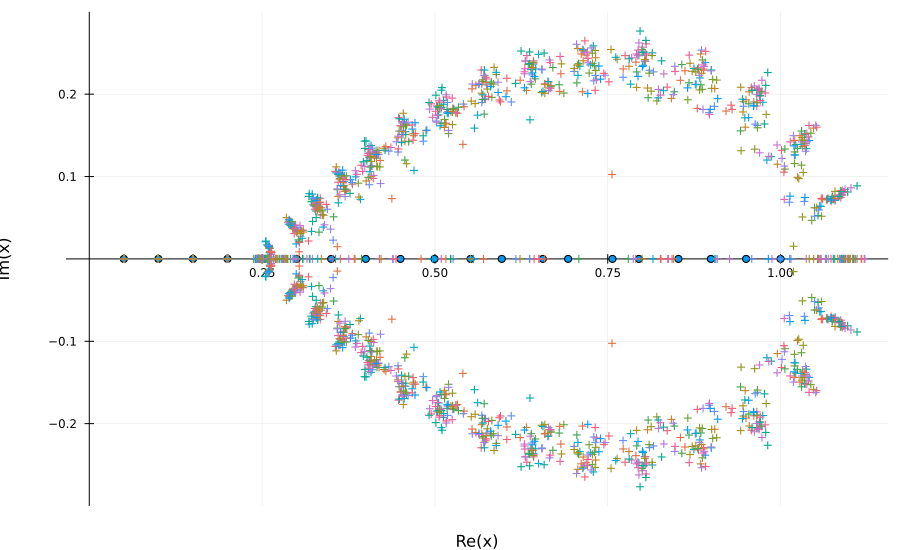

In [9]:
for i = 1:100
    newr = roots(Polynomial(coeffs(p).*(1. .+ randn(21).*1.e-10)))
    plot!(plt,newr, st=:scatter, m=:+)
end
plot(plt)

### Example: eigenvalues

In [10]:
A = [[1.0, 0.0] [1000.0, 1.0]]
Ap = copy(A); Ap[2,1] = 0.001
display(A)
display(Ap)

2×2 Matrix{Float64}:
 1.0  1000.0
 0.0     1.0

2×2 Matrix{Float64}:
 1.0    1000.0
 0.001     1.0

In [11]:
eigvals(Ap)

2-element Vector{Float64}:
 0.0
 2.0

In [12]:
eigvals(A)

2-element Vector{Float64}:
 1.0
 1.0

## Condition of Matrix-Vector Multiplication

- data: $x \in \mathbb{C}^{n}$
- solution: $Ax \in \mathbb{C}^m$

$$\kappa = \sup_{\delta x}\frac{\left(\frac{\|A(x + \delta x) - Ax\|}{\|Ax\|}\right)}{\left(\frac{\|\delta x\|}{\|x\|}\right) }= \sup_{\delta x}\frac{\left(\frac{\|A\delta x\|}{\|Ax\|}\right)}{\left(\frac{\|\delta x\|}{\|x\|}\right)}= \sup_{\delta x}\frac{\left(\frac{\|A\delta x\|}{\|\delta x\|}\right)}{\left(\frac{\|Ax\|}{\|x\|}\right)} = \frac{\sup_{\delta x}\|A\delta x\| / \|\delta x\|}{\|A x\| / \|x\|}=
\frac{\|A\|}{\|Ax\|/\|x\|}=\|A\|\frac{\|x\|}{\|Ax\|}$$

### Condition number for a Matrix-Vector Multiplication,  Nonsingular $A$

Use

$$\|x\| = \|A^{-1} Ax\| \leq \|A^{-1}\|\|Ax\|$$

$$\kappa = \|A\|\frac{\|x\|}{\|Ax\|} \leq \|A\|\|A^{-1}\|$$

Is this tight: is there $x$ such that $\kappa = \|A\|\|A^{-1}\|?$

### Mathematically, $x \gets A^{-1}b$ is just multiplication by $A^{-1}$

So we have shown

**T&B Theorem 12.1.**

The condition number of computing $b \gets Ax$ with respect to perturbations in $x$ is

$$\kappa = \|A\|\frac{\|x\|}{\|Ax\|} \leq \|A\| \|A^{-1}\|.$$

The condition number of computing $x \gets A^{-1}b$ with respect to perturbations in $b$ is

$$\kappa = \|A^{-1}\|\frac{\|b\|}{\|x\|} \leq \|A\| \|A^{-1}\|.$$

If $\|\cdot\| = \|\cdot\|_2$, equality holds if $x$ is the last right singular vector (associated with $\sigma_m$),
or if $b$ is the first left singular vector (associated with $\sigma_1$).

### Generalizing to the pseudoinverse

If $A\in\mathbb{C}^{m \times n}$ is rank $n$, the 2-norm condition number of multiplying by $A$ or $A^+$ is

$$
\kappa(A) = \kappa_2(A) = \frac{\sigma_1}{\sigma_n}.
$$

## Condition of a System of Equations

Change what is considered data in $x \gets A^{-1} b$.

- data: $A$
- solution: $b$

### Implicit perturbation conditions

Suppose $A$ is invertible and $Ax = b$.  The perturbation of $x$ with respect to $A$ is an _implicit_ condition:

$$(A + \delta A)(x + \delta x) = b.$$

$$Ax + A\delta x + (\delta A) x + \underbrace{(\delta A) \delta x}_{\text{drop double infinitesimals}} = b.$$

$$A\delta x + (\delta A) x = 0.$$

$$\delta x = -A^{-1} (\delta A) x.$$

### Equation into condition form

$\delta x = -A^{-1} (\delta A) x$, so

$$\frac{\|\delta x\| / \|x\|}{\|\delta A\|/\|A\|} \leq \frac{\|A^{-1}\| \|\delta A\|}{\|\delta A\|/\|A\|} = \|A\|\|A^{-1}\| = \kappa(A).$$

**T&B Theorem 12.2.** The condition number of $x \gets Ab$ with respect to perturbations in $A$ is

$$\kappa = \|A\|\|A^{-1}\| = \kappa(A).$$

> If a problem $Ax = b$ contains an ill-conditioned matrix $A$, one may always expect to "lose $\log_{10} \kappa(A)$ digits" in computing the solution, except under very special circumstances.

### Exercise

**T&B Exercise 12.1.**  Suppose $A$ is a $202 \times 202$ matrix with $\|A\|_2 = 100$ and $\|A\|_F = 101.$ Give the sharpest possible lower-bound on the 2-norm condition number $\kappa(A).$

$$\sigma_1^2+\cdots+\sigma_{202}^2=\|A\|_F=101^2\Rightarrow \sigma_2^2+\cdots+\sigma_{202}^2=101^2-1002$$
$$201\sigma_{202}^2\leq \sigma_2^2+\cdots+\sigma_{202}^2=101^2-100^2\Rightarrow \sigma_{202}^2\leq \frac{101^2-100^2}{201}$$
$$\kappa_2(A)=\frac{\sigma_1}{\sigma_{202}}=\frac{100}{\sigma_{202}}\geq\frac{100\sqrt{201}}{\sqrt{101^2-100^2}}$$